In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% !important; }</style>"))

In [23]:
import IPython
from IPython.display import display

import io
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import PIL
import cv2

import sneks
import gym

import torch
import torch.nn as nn

In [3]:
env = gym.make('snek-rgb-16-v1')

observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)

env.action_space, env.observation_space

(Discrete(4), Box(16, 16, 3))

In [4]:
# https://github.com/NicksonYap/Jupyter-Webcam/blob/master/Realtime_video_ipython_py3.ipynb
def show_array(a, prev_display_id=None, fmt='jpeg'):
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    IPython.display.display(obj)

In [138]:
def show_live_env(env, controller):

    try:
        while True:
            f = 0
            obs = env.reset()
            while True:
                IPython.display.clear_output(wait=True)
                time.sleep(1 / 30)
                f += 1

                action = controller(f, obs)
                obs, _, done, _ = env.step(action)
                frame = env.render('rgb_array')
                show_array(frame)
                if done: break
    except KeyboardInterrupt:
        show_array(frame) # show last frame
        print('stream interrupted')

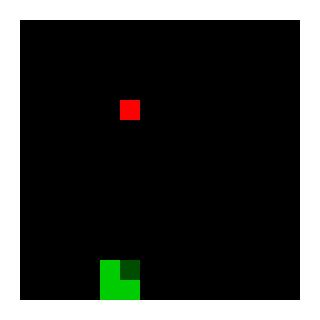

stream interrupted


In [139]:
def controller(f, obs):
    return env.action_space.sample()
    if done:
        raise KeyboardInterrupt()

show_live_env(env, controller)

In [206]:
obs_size = 16 * 16 * 3
num_actions = 4
hidden_dim = 512

def dense(i, o, a=nn.Sigmoid):
    l = nn.Linear(i, o)
#     l.weight.data = torch.normal(2, 2, (o, i))
#     l.bias.data = torch.normal(2, 2, (o,))
    return nn.Sequential(l, a())

q_net = nn.Sequential(
    nn.Flatten(),
    dense(obs_size, hidden_dim, nn.ReLU),
    dense(hidden_dim, hidden_dim, nn.ReLU),
    dense(hidden_dim, hidden_dim, nn.ReLU),
    dense(hidden_dim, hidden_dim, nn.ReLU),
    dense(hidden_dim, hidden_dim, nn.ReLU),
    nn.Linear(hidden_dim, num_actions),
)

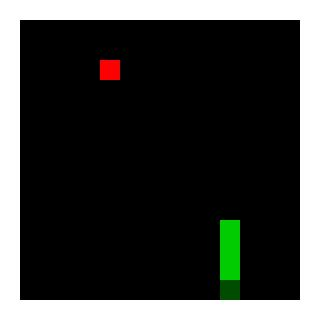

stream interrupted


In [207]:
def q_net_controller(f, obs):
    obs = torch.tensor(obs[np.newaxis, ...] // 255, dtype=torch.float32)
    q_vals = q_net(obs)
    action = q_vals.argmax()
    return action

    if done:
        raise KeyboardInterrupt()

show_live_env(env, controller)

In [208]:
def play_episode(env, model):
    max_rollout_steps = 100
    discount = 0.5
    ee_tradeoff = 0.5
    obs = env.reset()
    all_obs = []
    all_actions = []
    all_rewards = []

    for _ in range(max_rollout_steps):
        if random.random() > ee_tradeoff:
            torch_obs = torch.tensor(obs[np.newaxis, ...] / 255, dtype=torch.float32)
            q_vals = model(torch_obs)[0]
            max_action = q_vals.argmax()
        else:
            max_action = env.action_space.sample()
        
        obs, reward, done, info = env.step(max_action)
        all_obs.append(obs)
        all_actions.append(max_action)
        all_rewards.append(reward)
        if done: break

    q_vals = [
        sum([discount **j * r for j, r in enumerate(all_rewards[i:])])
        for i in range(len(all_rewards))
    ]

    return (
        np.array(all_obs) / 255,
        np.array(all_actions),
        np.array(q_vals),
    )

obs, actions, rewards = play_episode(env, q_net)
obs.shape, actions.shape, rewards.shape

((6, 16, 16, 3), (6,), (6,))

In [213]:
def dqn_optimize(env, model):
    experience_pool = []
    max_experiences = 500
    its =  300
    bs = 32
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters())

    def optimization_step():
        batch = random.sample(experience_pool, min(len(experience_pool), bs))
        obs = torch.cat([torch.tensor(o, dtype=torch.float32) for o, a, r in batch])
        actions = torch.cat([torch.tensor(a, dtype=torch.long) for o, a, r in batch])
        q_vals = torch.cat([torch.tensor(r, dtype=torch.float32) for o, a, r in batch])

        optimizer.zero_grad()
        q_vals_pred = model(obs)
        used_q_vals = torch.index_select(q_vals_pred, dim=1, index=actions)[0]
        loss = criterion(used_q_vals, q_vals)
        loss.backward()
        optimizer.step()

        return loss.item()


    tr = trange(its, bar_format='{desc} {bar}')
    for i in tr:
        episode = play_episode(env, model)
        experience_pool.append(episode)
        loss = optimization_step()
        tr.set_description('Its %i/%i | Loss: %.6f' % (i + 1, its, loss))

        if len(experience_pool) > max_experiences:
            experience_pool = experience_pool[1:]

In [ ]:
dqn_optimize(env, q_net)

In [ ]:
show_live_env(env, q_net_controller)